In [1]:
import sys
sys.path.append("../") 

In [2]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 1
model_ctx = mx.gpu()

num_workers = 4
batch_size = 256 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(256, 1, 28, 28)
(256,)


In [6]:
model_ctx

gpu(0)

### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [7]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(1,28,28)
out_units=10

In [8]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import lenet

model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.1,ctx=model_ctx)

In [9]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.lenet)
    importlib.reload(hamiltonian.inference.sgd)
    importlib.reload(hamiltonian.inference.base)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


no modules loaded yet


In [9]:
train_sgd=False
num_epochs=100
import h5py

if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,data_loader=train_data,
                           chain_name='lenet_map.h5',verbose=True)

    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_lenet.pdf', bbox_inches='tight')
else:
    map_estimate=h5py.File('lenet_map.h5','r')
    par={var:map_estimate[var][:] for var in map_estimate.keys()}
    map_estimate.close()
    

In [10]:
model.net.collect_params()

{'0.weight': Parameter (shape=(6, 1, 5, 5), dtype=<class 'numpy.float32'>),
 '0.bias': Parameter (shape=(6,), dtype=<class 'numpy.float32'>),
 '2.weight': Parameter (shape=(16, 6, 5, 5), dtype=<class 'numpy.float32'>),
 '2.bias': Parameter (shape=(16,), dtype=<class 'numpy.float32'>),
 '4.weight': Parameter (shape=(120, 400), dtype=float32),
 '4.bias': Parameter (shape=(120,), dtype=float32),
 '5.weight': Parameter (shape=(84, 120), dtype=float32),
 '5.bias': Parameter (shape=(84,), dtype=float32),
 '6.weight': Parameter (shape=(10, 84), dtype=float32),
 '6.bias': Parameter (shape=(10,), dtype=float32)}

In [11]:
total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=100,data_loader=val_data)

In [12]:
y_hat=np.quantile(total_samples,.5,axis=0)

In [13]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       979
           1       1.00      0.99      1.00      1133
           2       0.99      0.99      0.99      1030
           3       0.99      0.99      0.99      1008
           4       0.99      0.99      0.99       980
           5       0.98      0.98      0.98       890
           6       0.99      0.99      0.99       956
           7       0.99      0.99      0.99      1027
           8       0.99      0.98      0.98       973
           9       0.99      0.98      0.99      1008

    accuracy                           0.99      9984
   macro avg       0.99      0.99      0.99      9984
weighted avg       0.99      0.99      0.99      9984



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [16]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import lenet

model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

In [17]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


  0%|          | 1/250 [00:15<1:05:01, 15.67s/it]

loss: 1.4166


 10%|█         | 26/250 [04:16<35:55,  9.62s/it] 

loss: 0.2575


 20%|██        | 51/250 [08:55<41:51, 12.62s/it]

loss: 0.2216


 30%|███       | 76/250 [14:17<38:04, 13.13s/it]

loss: 0.2271


 40%|████      | 101/250 [20:04<37:13, 14.99s/it]

loss: 0.2186


 50%|█████     | 126/250 [26:43<36:16, 17.55s/it]

loss: 0.1981


 60%|██████    | 151/250 [33:53<36:56, 22.39s/it]

loss: 0.1941


 70%|███████   | 176/250 [42:28<24:07, 19.56s/it]

loss: 0.1949


 80%|████████  | 201/250 [50:23<16:46, 20.54s/it]

loss: 0.1926


 90%|█████████ | 226/250 [58:28<07:50, 19.59s/it]

loss: 0.1947


  0%|          | 1/250 [00:21<1:29:19, 21.52s/it]

loss: 1.1535


 10%|█         | 26/250 [09:05<1:05:56, 17.66s/it]

loss: 0.2021


 20%|██        | 51/250 [17:08<57:33, 17.36s/it]  

loss: 0.1739


 30%|███       | 76/250 [25:06<56:42, 19.56s/it]  

loss: 0.1547


 40%|████      | 101/250 [33:17<53:12, 21.42s/it]

loss: 0.1464


 50%|█████     | 126/250 [42:14<44:12, 21.39s/it]

loss: 0.1411


 60%|██████    | 151/250 [50:46<33:21, 20.22s/it]

loss: 0.1394


 70%|███████   | 176/250 [59:10<24:52, 20.17s/it]

loss: 0.1334


 80%|████████  | 201/250 [1:07:07<15:22, 18.82s/it]

loss: 0.1321


 90%|█████████ | 226/250 [1:15:14<08:02, 20.09s/it]

loss: 0.1301


100%|██████████| 250/250 [1:22:32<00:00, 19.81s/it]


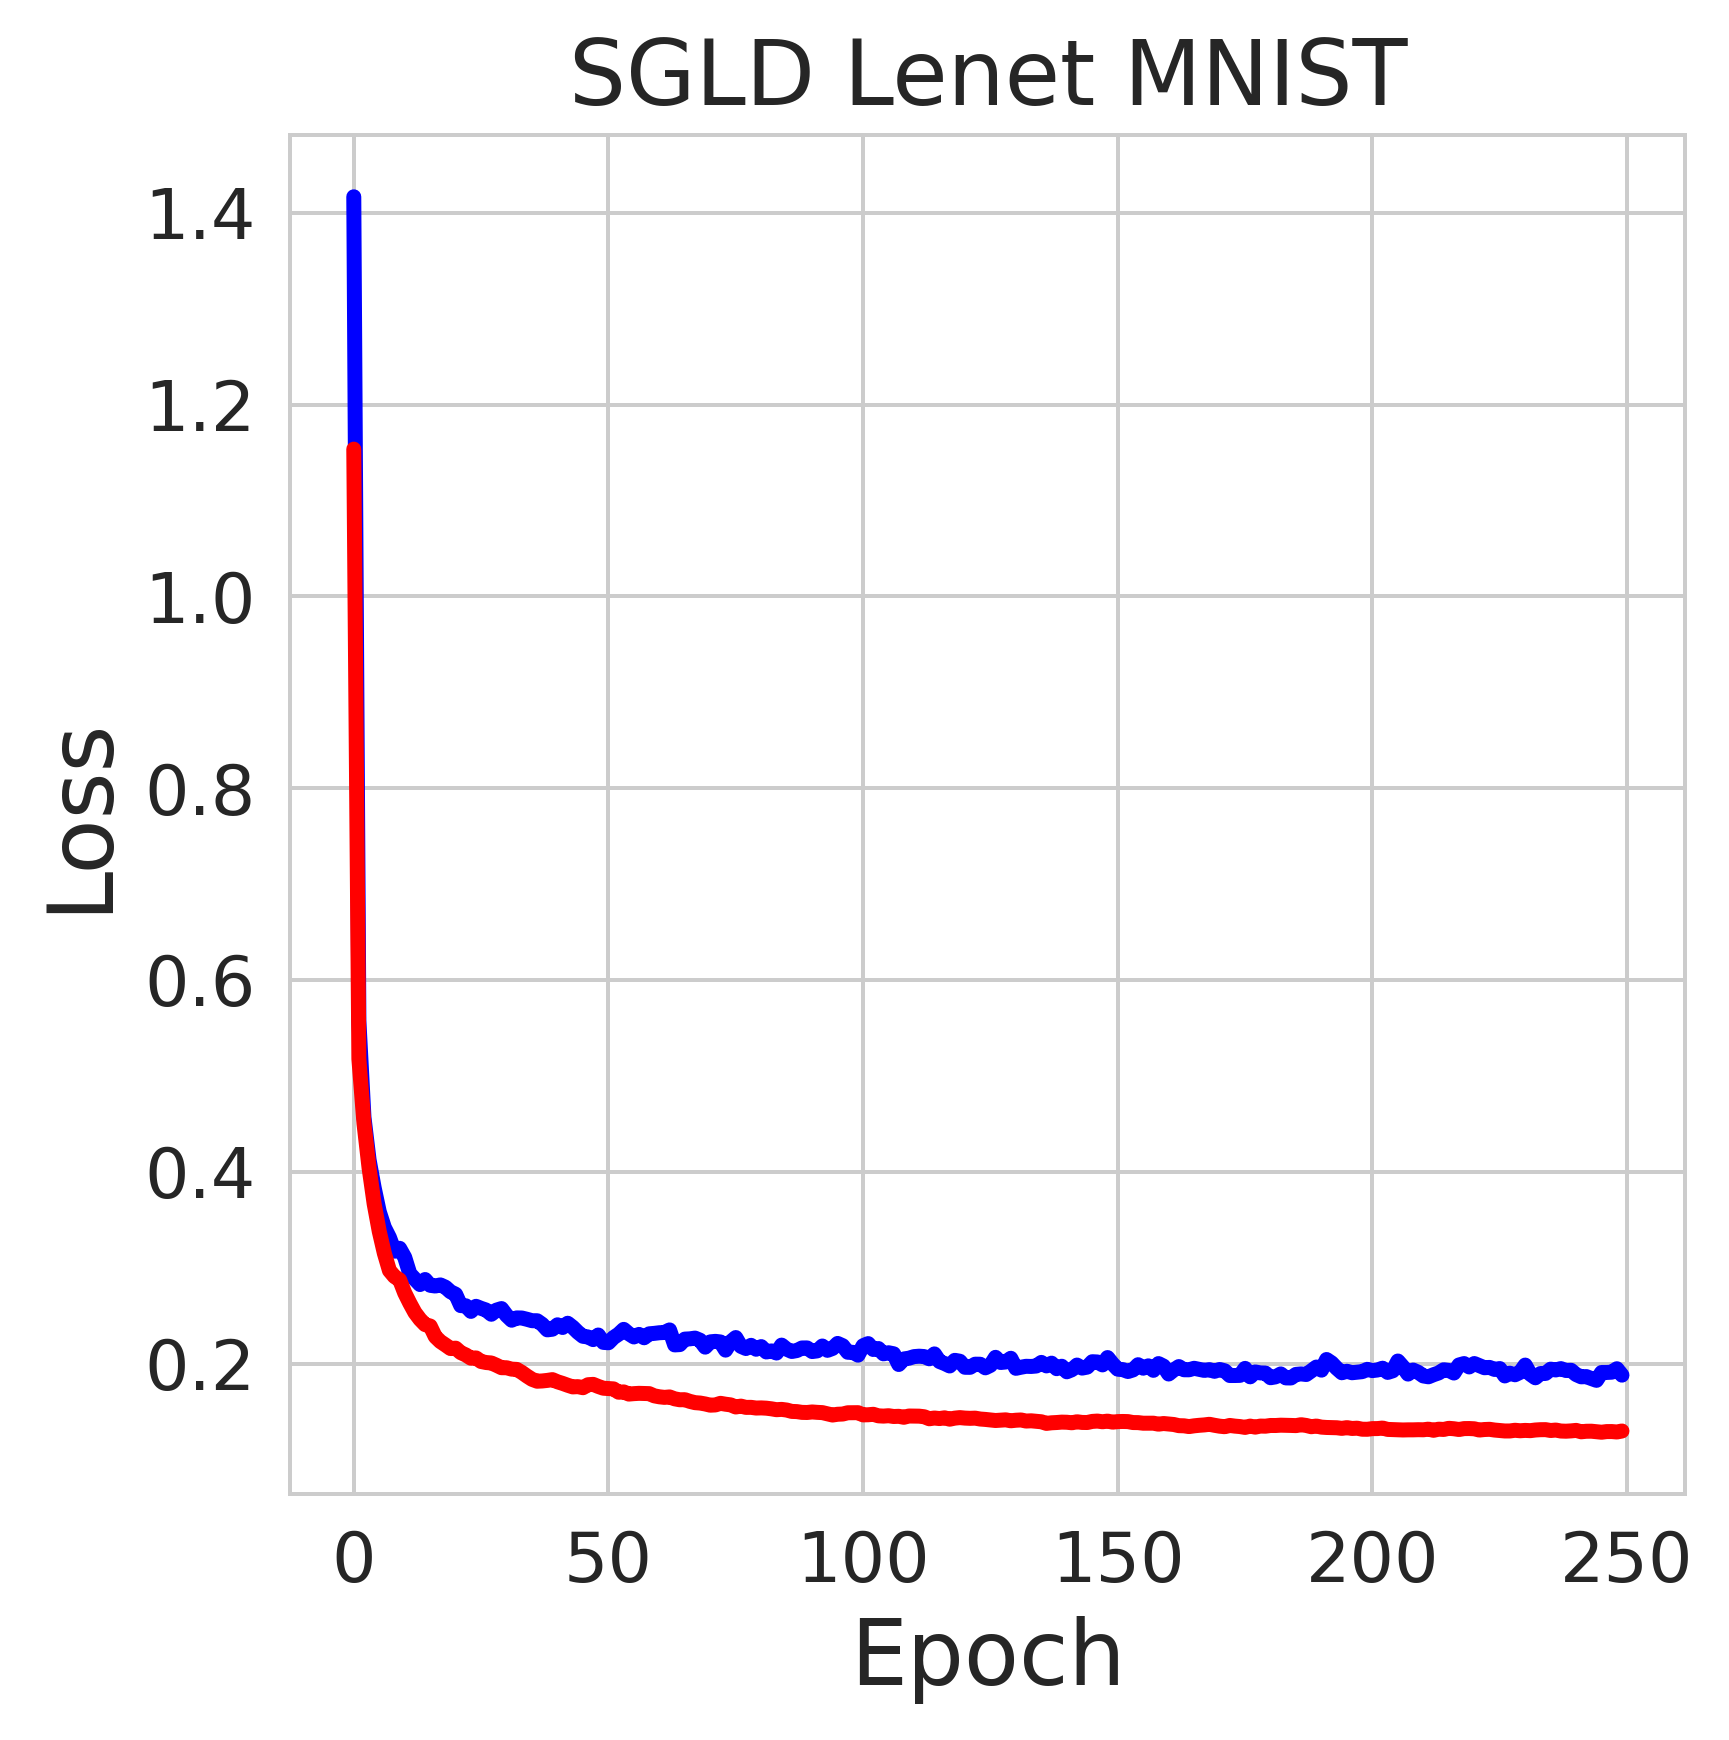

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=True
num_epochs=250

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='lenet_posterior.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_lenet.pdf', bbox_inches='tight')


In [19]:
import h5py 

posterior_samples=h5py.File('lenet_posterior.h5','r')

In [20]:
posterior_samples.keys()

<KeysViewHDF5 ['0.bias', '0.weight', '2.bias', '2.weight', '4.bias', '4.weight', '5.bias', '5.weight', '6.bias', '6.weight']>

In [21]:
posterior_samples['0.weight'].shape

(2, 250, 6, 1, 5, 5)

In [43]:
posterior_samples.close()

In [22]:
posterior_samples.attrs.keys()

<KeysViewHDF5 ['num_chains', 'num_samples']>

In [23]:
total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)

In [25]:
from sklearn.metrics import classification_report
posterior_samples

y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [27]:
from sklearn.metrics import f1_score

score=[]
for q in np.arange(.25,.75,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), average='macro'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.9814139580806435, std f-1 : 0.0077583250191183934


In [28]:
import arviz as az

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
dataset=az.convert_to_inference_data(samples)
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}

In [29]:
az.summary(dataset)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0.bias[0],-1.675,0.628,-2.476,-0.549,0.388,0.324,3.0,15.0,2.11
0.bias[1],0.070,1.992,-2.347,2.952,1.361,1.136,2.0,11.0,2.75
0.bias[2],-0.529,1.873,-2.733,2.531,1.267,1.053,2.0,12.0,2.77
0.bias[3],-0.674,1.675,-2.749,1.510,1.156,0.969,2.0,11.0,2.49
0.bias[4],-1.836,0.563,-2.812,-1.016,0.351,0.297,3.0,16.0,1.92
...,...,...,...,...,...,...,...,...,...
"6.weight[9,79]",0.579,0.538,-0.558,1.247,0.143,0.108,14.0,20.0,1.18
"6.weight[9,80]",-0.393,0.684,-1.800,0.537,0.432,0.350,3.0,21.0,1.79
"6.weight[9,81]",1.606,1.399,-0.571,3.709,0.925,0.762,3.0,13.0,2.13
"6.weight[9,82]",0.217,0.867,-1.024,1.427,0.582,0.482,3.0,15.0,1.88


In [30]:
print(mean_r_hat_values)

{'0.weight': 1.8911034118392664, '0.bias': 2.3420003998080765, '2.weight': 1.8781953439490522, '2.bias': 1.939083137369312, '4.weight': 1.862266946521165, '4.bias': 1.7839887152648544, '5.weight': 1.8571177972718445, '5.bias': 1.8761910006509688, '6.weight': 1.8503154251486995, '6.bias': 1.7211113677049639}


In [31]:
print(mean_ess_values)

{'0.weight': 3.8541840455760377, '0.bias': 2.574277731299679, '2.weight': 3.71329822427096, '2.bias': 3.3536408751813376, '4.weight': 3.7277996256444914, '4.bias': 3.79789306848236, '5.weight': 3.7059879263582203, '5.bias': 3.3630683844778906, '6.weight': 3.836261126757764, '6.bias': 3.90233063359844}


In [32]:
print(mean_mcse_values)

{'0.weight': 0.6582325053556355, '0.bias': 0.8319579150640949, '2.weight': 0.644429386665916, '2.bias': 0.5429942795826901, '4.weight': 0.6157063153819196, '4.bias': 0.5415762369655165, '5.weight': 0.6056398517903836, '5.bias': 0.6317864704448178, '6.weight': 0.5700457995526313, '6.bias': 0.44557334859268566}


In [34]:
from hamiltonian.utils.psis import *

loo,loos,ks=psisloo(-log_like)

In [46]:
np.sum(ks==max(ks))

4

In [35]:
from sklearn.metrics import f1_score

score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), sample_weight=loos,average='weighted'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.6116106846997926, std f-1 : 0.11644307083094219


# Hierarchical Lenet <a class="anchor" id="chapter3"></a>

In [54]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import hierarchical_lenet

model=hierarchical_lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

  0%|          | 1/250 [00:15<1:05:25, 15.77s/it]

loss: 1.8810


 10%|█         | 26/250 [07:32<1:17:20, 20.72s/it]

loss: 0.8006


 20%|██        | 51/250 [16:29<1:19:42, 24.03s/it]

loss: 0.8318


 30%|███       | 76/250 [26:34<1:11:23, 24.62s/it]

loss: 0.7385


 40%|████      | 101/250 [37:28<1:05:26, 26.35s/it]

loss: 1.2942


 50%|█████     | 126/250 [48:19<54:55, 26.57s/it]  

loss: 0.8664


 60%|██████    | 151/250 [59:00<41:27, 25.13s/it]

loss: 0.6829


 70%|███████   | 176/250 [1:08:45<27:55, 22.64s/it]

loss: 0.6753


 80%|████████  | 201/250 [1:18:59<21:20, 26.13s/it]

loss: 0.7898


 90%|█████████ | 226/250 [1:29:57<10:36, 26.51s/it]

loss: 0.7386


  0%|          | 1/250 [00:25<1:46:20, 25.63s/it]

loss: 1.8508


 10%|█         | 26/250 [11:17<1:38:11, 26.30s/it]

loss: 0.8526


 20%|██        | 51/250 [22:09<1:25:53, 25.90s/it]

loss: 10.1775


 30%|███       | 76/250 [32:41<1:12:12, 24.90s/it]

loss: 0.7519


 40%|████      | 101/250 [42:51<1:00:34, 24.39s/it]

loss: 0.9849


 50%|█████     | 126/250 [53:00<50:16, 24.33s/it]  

loss: 0.9360


 60%|██████    | 151/250 [1:03:10<40:19, 24.44s/it]

loss: 0.9360


 70%|███████   | 176/250 [1:13:38<30:15, 24.54s/it]

loss: 0.7513


 80%|████████  | 201/250 [1:23:48<19:53, 24.36s/it]

loss: 0.7268


 90%|█████████ | 226/250 [1:33:59<09:47, 24.49s/it]

loss: 0.7567


100%|██████████| 250/250 [1:43:44<00:00, 24.90s/it]


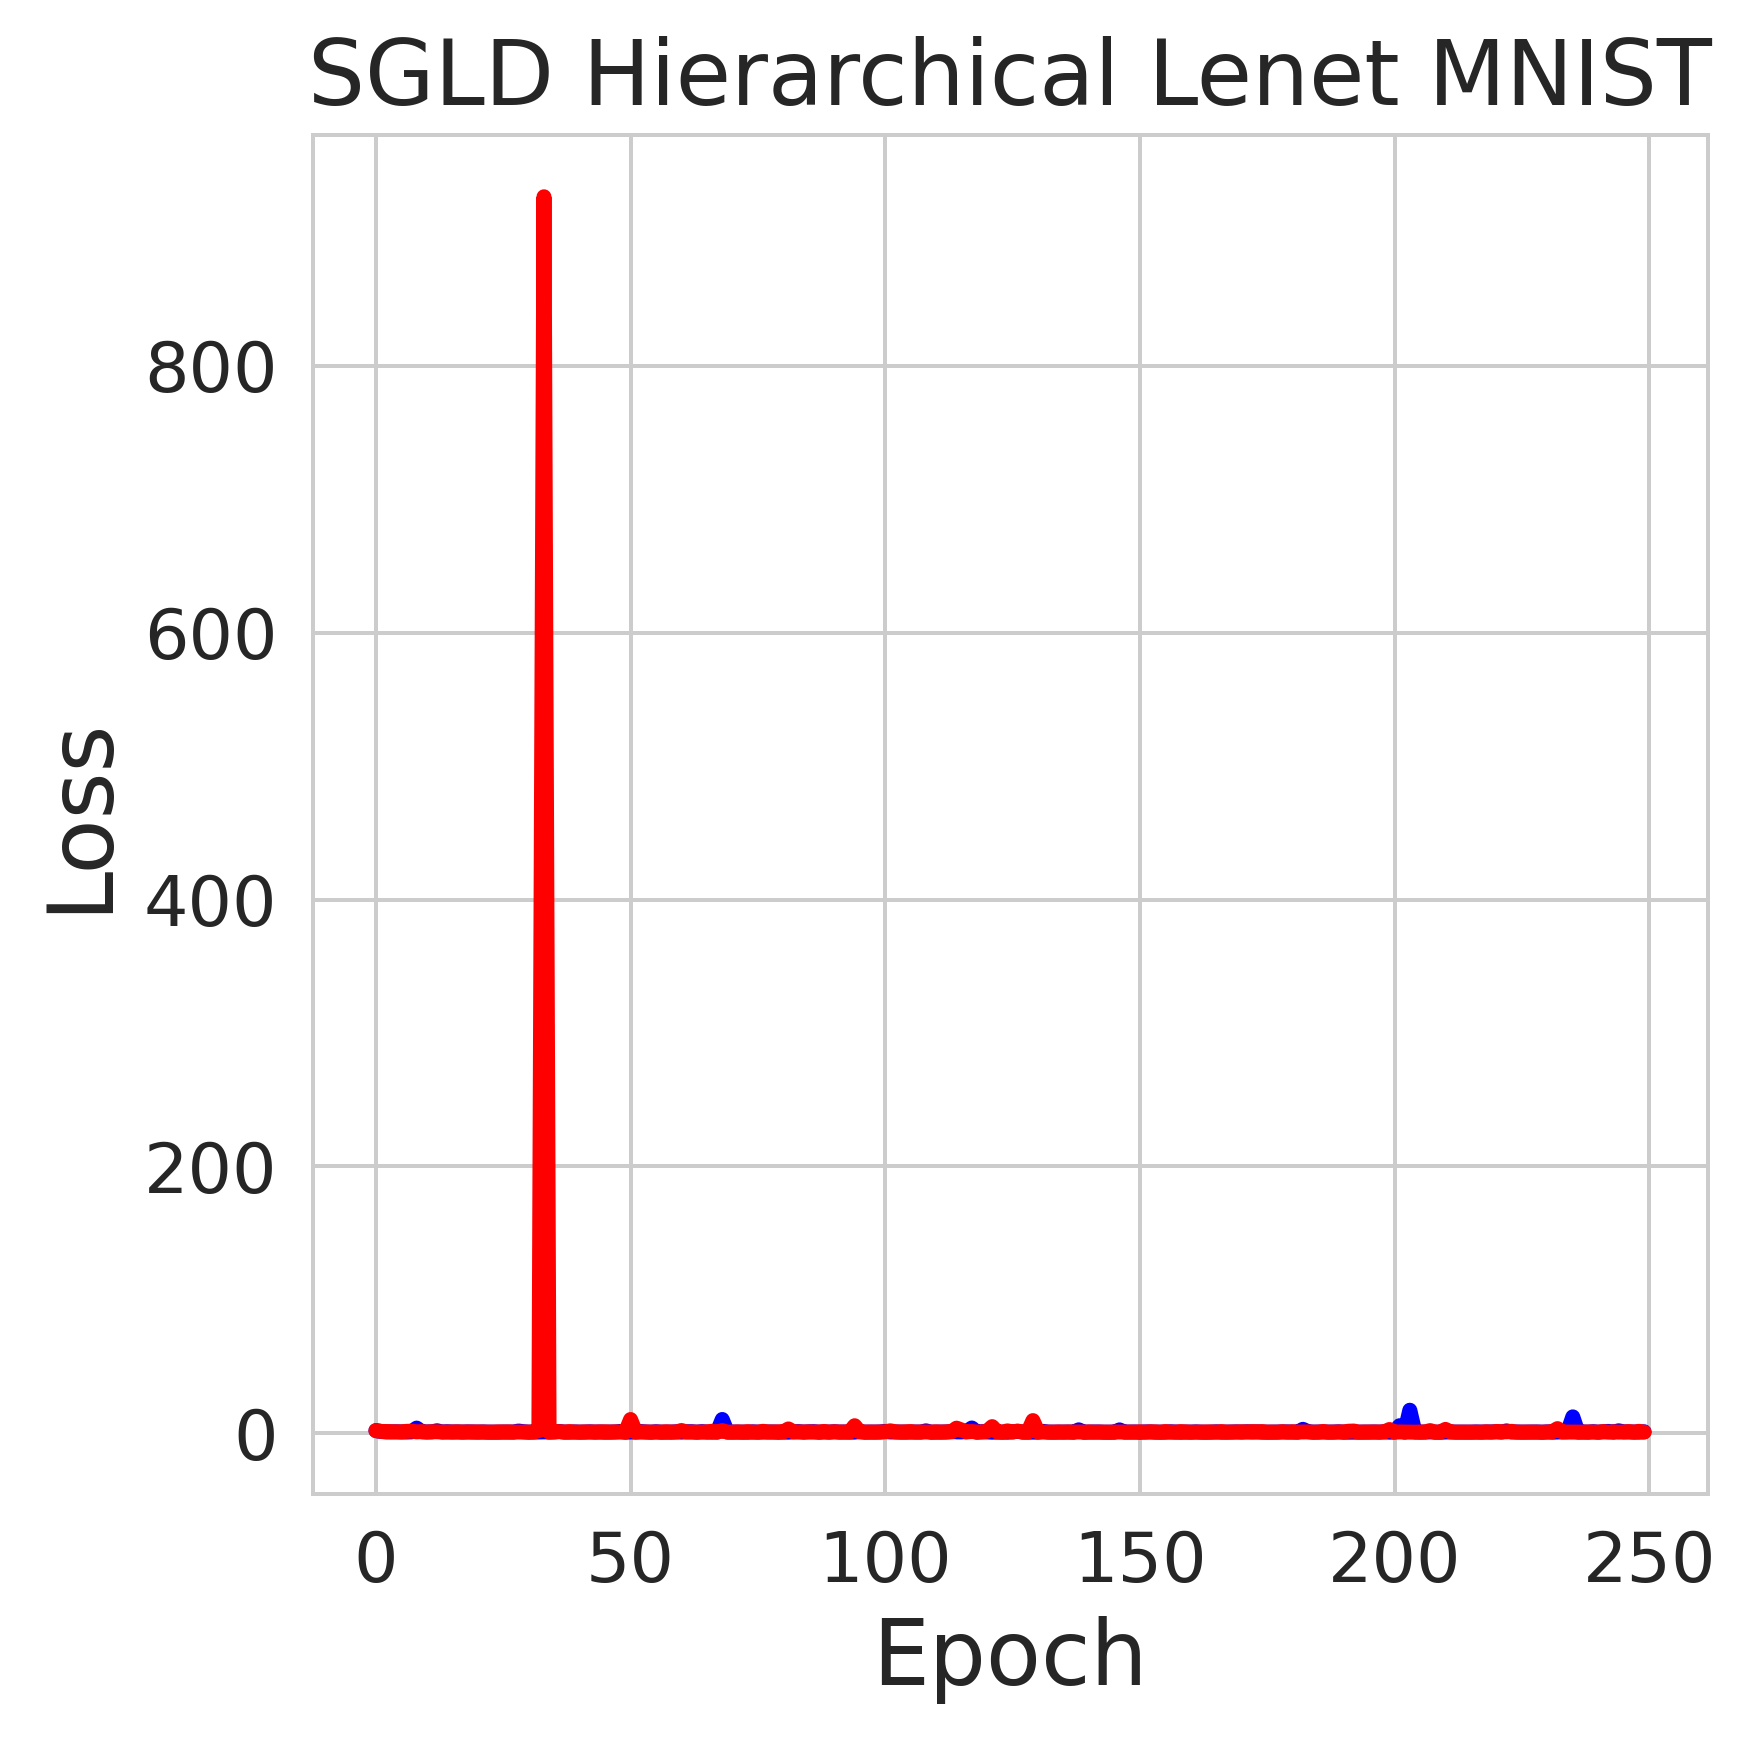

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=True
num_epochs=250

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='hierarchical_lenet_posterior.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Hierarchical Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_hierarchical_lenet.pdf', bbox_inches='tight')


In [56]:
import h5py 

posterior_samples=h5py.File('hierarchical_lenet_posterior.h5','r')

In [57]:
posterior_samples.attrs.keys()

<KeysViewHDF5 ['num_chains', 'num_samples']>

In [59]:
total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)

In [61]:
from sklearn.metrics import classification_report


y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.99      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.97      0.97      0.97       974
           9       1.00      0.96      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [63]:
import arviz as az

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
dataset=az.convert_to_inference_data(samples)
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}

In [64]:
print(mean_r_hat_values)

{'0.weight': 1.899893412253319, '0.bias': 1.7730439318976332, '2.weight': 1.8697946462707042, '2.bias': 1.2315434912556795, '4.weight': 1.864611287605658, '4.bias': 1.6630358197832535, '5.weight': 1.8545123341066623, '5.bias': 1.5839121923013706, '6.weight': 1.7627512867812443, '6.bias': 1.1201016490631857}


In [65]:
print(mean_ess_values)

{'0.weight': 3.6522486306312065, '0.bias': 4.528557642665192, '2.weight': 3.6939412118901584, '2.bias': 10.9654691967942, '4.weight': 3.7126951819386345, '4.bias': 4.503388480684211, '5.weight': 3.7444695013403115, '5.bias': 5.2474399398934075, '6.weight': 4.065680187456601, '6.bias': 21.89768378183614}
